In [1]:
import sys


sys.path.append("/home/caio/dev")

In [2]:
import torch
import pandas as pd
import pickle


from dynamicTasteDistortion.dataset_loader import get_ml_df
from bprMf.bpr_mf import bprMf
from dynamicTasteDistortion.dynamicTasteDistortion.scripts.data_utils import standardize_ids

from dynamicTasteDistortion.dynamicTasteDistortion.preference_model import split_train_test_per_user


In [3]:
from dynamicTasteDistortion.dynamicTasteDistortion.scripts.model_utils import ModelChooser

In [4]:


data_type = "ml"
size = "s"

df = get_ml_df(size)
df["relevant"] = df["binarized_rating"]
processed_df, _, _ = standardize_ids(df)

train_df, test_df = split_train_test_per_user(processed_df)

Skipping: 'dynamicTasteDistortion/data/movielens/raw/ml_s/' already exists and contains files.
Joining movies data with ratings data...
Preprocessing dataset...


In [5]:
train_df

,item,genres,user,rating,timestamp,binarized_rating,relevant
0,2964,[drama],0,4,978300019,1,1
1,1176,"[comedy, sci-fi]",0,5,978300055,1,1
2,1571,"[drama, romance]",0,4,978300055,1,1
3,955,"[animation, children's, musical]",0,5,978300055,1,1
4,2142,[romance],0,3,978300103,0,0
...,...,...,...,...,...,...,...
783513,2438,[horror],5288,5,960971797,1,1
783514,1340,[comedy],5288,3,960971857,0,0
783515,3266,"[comedy, drama]",5288,4,960971857,1,1
783516,2106,"[drama, musical]",5288,5,960971857,1,1


In [6]:
test_df

,item,genres,user,rating,timestamp,binarized_rating,relevant
0,0,"[animation, children's, comedy]",0,5,978824268,1,1
1,574,"[animation, children's, comedy, musical]",0,4,978824268,1,1
2,707,"[animation, comedy, thriller]",0,3,978824268,0,0
3,581,"[animation, children's, musical]",0,5,978824268,1,1
4,2478,"[animation, children's]",0,3,978824268,0,0
...,...,...,...,...,...,...,...
198517,2704,"[crime, thriller]",5288,4,997454429,1,1
198518,1736,"[sci-fi, thriller]",5288,4,997454464,1,1
198519,1615,"[comedy, drama]",5288,3,997454464,0,0
198520,155,"[drama, thriller, war]",5288,3,997454486,0,0


In [7]:
processed_df

,item,genres,user,rating,timestamp,binarized_rating,relevant
0,0,"[animation, children's, comedy]",0,5,978824268,1,1
1,0,"[animation, children's, comedy]",4,4,978237008,1,1
2,0,"[animation, children's, comedy]",6,4,978233496,1,1
3,0,"[animation, children's, comedy]",7,5,978225952,1,1
4,0,"[animation, children's, comedy]",8,5,978226474,1,1
...,...,...,...,...,...,...,...
1000204,3700,"[drama, thriller]",5080,4,992072099,1,1
1000205,3700,"[drama, thriller]",5096,3,986223125,0,0
1000206,3700,"[drama, thriller]",5102,4,1011902656,1,1
1000207,3700,"[drama, thriller]",5183,1,979852537,0,0


In [8]:
n_users = processed_df["user"].max() + 1
n_items = processed_df["item"].max() + 1


### Training BPR model on df

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
from itertools import product
param_grid_bpr = {
    "factors": [32, 64, 128],
    "n_epochs": [5, 10, 20],
    "lr": [0.005, 0.01, 0.02],
    "reg_lambda": [1e-3, 1e-2]
}
combinations = list(product(*param_grid_bpr.values()))

In [11]:
param_names = list(param_grid_bpr.keys())

In [12]:
param_names

['factors', 'n_epochs', 'lr', 'reg_lambda']

In [13]:
dicts = [dict(zip(param_names, values)) for values in combinations]

In [14]:

# from tqdm import tqdm
# best_map = -1.0
# best_params = None


# for param in tqdm(dicts, desc="Hyperparameter Tuning"):
#     print(f"Testing parameters: {param}")
    
#     # Initialize model with the current set of hyperparameters
#     model = bprMf(
#         num_users=n_users,
#         num_items=n_items,
#         dev=device,
#         **param
#     )
    
#     # Train the model
#     model.fit(train_df)
    
#     # Evaluate performance (MAP is the standard metric here)
#     current_map = model.evaluate(train_df, test_df)
#     print(f"MAP@20: {current_map:.4f}")
    
#     # Check if this is the best version so far
#     if current_map > best_map:
#         best_map = current_map
#         best_params = param

# print("--- Optimization Complete ---")
# print(f"Best MAP: {best_map:.4f}")
# print(f"Best Configuration: {best_params}")

In [15]:
path = "/home/caio/dev/dynamicTasteDistortion/dynamicTasteDistortion/artifacts/model"

In [16]:
best_params = {'factors': 32, 'n_epochs': 5, 'lr': 0.01, 'reg_lambda': 0.01}

In [17]:
with open(f"{path}/ml_1m_best_bpr_model.pkl", "wb") as f:
    pickle.dump(best_params, f)



In [18]:
with open(f"{path}/ml_1m_best_bpr_model.pkl", "rb") as f:
    best_params = pickle.load(f)

In [19]:


best_model  = bprMf(
        num_users=n_users,
        num_items=n_items,
        dev=device,
        **best_params
    )

In [20]:
best_model.evaluate(train_df, test_df)

0.001525428452118946

In [21]:
best_model.fit(train_df)

Epochs: 100%|██████████| 5/5 [00:56<00:00, 11.40s/it]


[0.3463050133392904,
 0.2737197644769933,
 0.26859924791122247,
 0.2667148787780164,
 0.2657746288700036]

In [22]:
for k in [1, 5, 10, 20, 50]:
    map_k = best_model.evaluate(train_df, test_df, k=k)
    print(f"k:{k}; map: {map_k}")

k:1; map: 0.1044605413648494
k:5; map: 0.05524283051637226
k:10; map: 0.043921698863389126
k:20; map: 0.03976812782540827
k:50; map: 0.04416868990989596


### Generating predictions and measuring baseline MACE and avg kl div

In [23]:
from calibratedRecs.calibration import Calibration

In [45]:
rec_df = best_model.score(processed_df).rename(
            columns={"top_k_rec_id": "item", "top_k_rec_score": "rating"}
        ).explode(["item", "rating"])

In [ ]:
calibrator_base = Calibration(ratings_df=processed_df, recommendation_df=rec_df, n_users=n_users, n_items=n_items)

In [39]:
calibrator_base.get_avg_kl_div(source="uncalibrated")

0.3036816573148358

In [40]:
calibrator_base._mace()

torch.Size([5289, 100])


0.02612404152750969

In [41]:
calibrator_base.calibrate_for_users()

100%|██████████| 5289/5289 [12:45<00:00,  6.91it/s]


In [42]:
calibrator_base.get_avg_kl_div(source="calibrated")

0.20161063817731534

### Calibrating predictions for different lambdas, measuring MACE and avg kl div

In [ ]:
lambdas = [i/10 for i in list(range(11))]

In [56]:
lambdas

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [57]:
from tqdm import tqdm

In [61]:
kl_divs = []
maces = []

for l in tqdm(lambdas, desc="Calibrating for different lambdas..."):
    calibrator = Calibration(ratings_df=processed_df, recommendation_df=rec_df, n_users=n_users, n_items=n_items, _lambda=l)
    calibrator.calibrate_for_users()
    kl = calibrator.get_avg_kl_div(source="calibrated")
    mace = calibrator._mace()

    kl_divs.append(kl)
    maces.append(mace)


Calibrating for different lambdas...:  10%|█         | 1/10 [13:07<1:58:11, 787.95s/it]

torch.Size([5289, 20])


Calibrating for different lambdas...:  20%|██        | 2/10 [25:56<1:43:34, 776.75s/it]

torch.Size([5289, 20])


Calibrating for different lambdas...:  30%|███       | 3/10 [38:46<1:30:15, 773.68s/it]

torch.Size([5289, 20])


Calibrating for different lambdas...:  40%|████      | 4/10 [51:27<1:16:51, 768.55s/it]

torch.Size([5289, 20])


Calibrating for different lambdas...:  50%|█████     | 5/10 [1:04:14<1:04:00, 768.12s/it]

torch.Size([5289, 20])


Calibrating for different lambdas...:  60%|██████    | 6/10 [1:17:45<52:10, 782.51s/it]  

torch.Size([5289, 20])


Calibrating for different lambdas...:  70%|███████   | 7/10 [1:30:52<39:11, 783.92s/it]

torch.Size([5289, 20])


Calibrating for different lambdas...:  80%|████████  | 8/10 [1:43:31<25:52, 776.09s/it]

torch.Size([5289, 20])


Calibrating for different lambdas...:  90%|█████████ | 9/10 [1:56:16<12:52, 772.76s/it]

torch.Size([5289, 20])


Calibrating for different lambdas...: 100%|██████████| 10/10 [2:08:58<00:00, 773.89s/it]

torch.Size([5289, 20])


In [62]:
maces

[0.03551303595304489,
 0.03332619369029999,
 0.031845275312662125,
 0.03071322664618492,
 0.02965344302356243,
 0.028588633984327316,
 0.027413897216320038,
 0.025959454476833344,
 0.023817090317606926,
 0.01937095634639263]

In [63]:
kl_divs

[1.423572265858415,
 1.1724461541467273,
 0.9765487674501876,
 0.8163058542716727,
 0.6849167162824001,
 0.5634781126405548,
 0.45689835584879,
 0.3651455131331753,
 0.28210148050652817,
 0.19758177957053621]

In [66]:
from matplotlib import pyplot as plt

In [70]:
calibrator_base.get_avg_kl_div(source="uncalibrated")

0.3036816573148358

In [71]:
lambdas

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [73]:
baseline_kl_div = calibrator_base.get_avg_kl_div(source="uncalibrated")

In [74]:
baseline_mace = Calibration(ratings_df=processed_df, recommendation_df=rec_df, n_users=n_users, n_items=n_items, _lambda=l)._mace()

torch.Size([5289, 100])


In [75]:
baseline_mace

0.02612404152750969

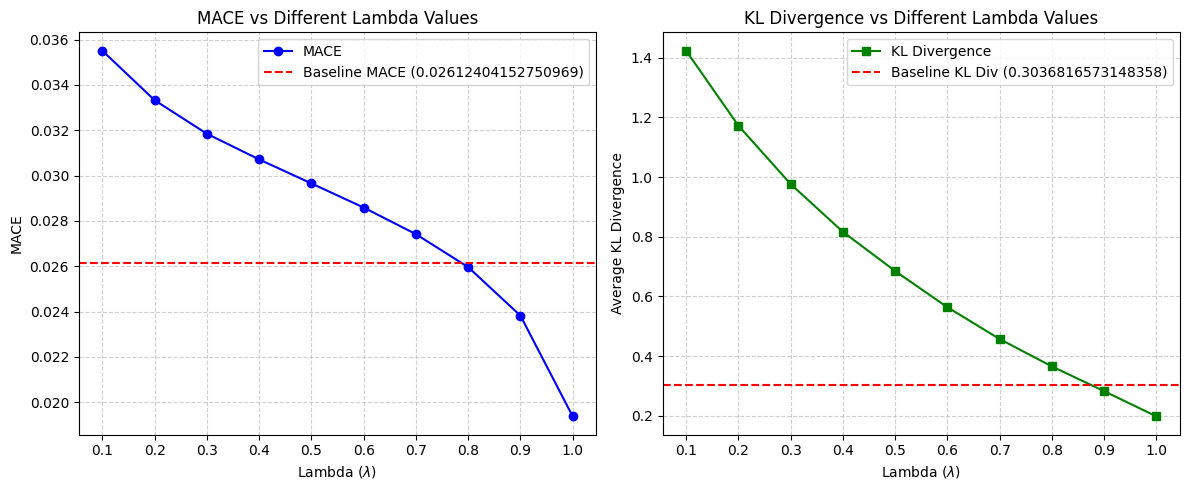

In [76]:
plt.rcParams["figure.figsize"] = (12, 5)

# Plot 1: MACE vs Lambda
plt.subplot(1, 2, 1) # (rows, columns, index)
plt.plot(lambdas, maces, marker='o', linestyle='-', color='blue', label='MACE')
plt.title('MACE vs Different Lambda Values')
plt.axhline(y=baseline_mace, color='red', linestyle='--', label=f'Baseline MACE ({baseline_mace})')
plt.xticks(lambdas)
plt.xlabel('Lambda ($\lambda$)')
plt.ylabel('MACE')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Plot 2: KL Divergence vs Lambda
plt.subplot(1, 2, 2)
plt.plot(lambdas, kl_divs, marker='s', linestyle='-', color='green', label='KL Divergence')
plt.axhline(y=baseline_kl_div, color='red', linestyle='--', label=f'Baseline KL Div ({baseline_kl_div})')
plt.title('KL Divergence vs Different Lambda Values')
plt.xticks(lambdas)
plt.xlabel('Lambda ($\lambda$)')
plt.ylabel('Average KL Divergence')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout() # Prevents label overlapping

In [77]:
kl_divs

[1.423572265858415,
 1.1724461541467273,
 0.9765487674501876,
 0.8163058542716727,
 0.6849167162824001,
 0.5634781126405548,
 0.45689835584879,
 0.3651455131331753,
 0.28210148050652817,
 0.19758177957053621]